# Path Signatures for Early Sepsis Detection

This notebook is based on the work of Ni et al. (2021). This work builds on the winning approach by Morrill et al. of the [PhysioNet Computing in Cardiology Challenge 2019](https://physionet.org/content/challenge-2019/1.0.0/), by building a [real-time sepsis analysis pipeline](https://github.com/HangL-39/Mimiciii_Sepsis_Label_Extraction) to train and evaluate a suite of representative models against the MIMIC III dataset. Whereas the analysis pipeline incorporates light gradient boosting machine (LGBM), long short term memory (LSTM) and Cox proportional hazards (CoxPHM) models, this notebook showcases the application of LGBMs as one example, in a simplified setting. For more information on the aforementioned research, please see the following references:

> Ni, H., Cohen, S., Lou, H.,  Morrill, J. , Wu, Y., Yang, L., Lyons, T.: Variation of sepsis-III definitions influences predictive performance of machine learning. Manuscript submitted for publication (2021).

> Morrill, J., Kormilitzin, A., Nevado-Holgado, A., Swaminathan, S., Howison, S., Lyons, T.: The signature-based
model for early detection of sepsis from electronic health records in the intensive care unit. In: 2019 Computing
in Cardiology (CinC) (2019).

> Morrill, J., Kormilitzin, A., Nevado-Holgado, A., Swaminathan, S., Howison, S., Lyons, T.: Utilization
of the signature method to identify the early onset of sepsis from multivariate physiological time series in
critical care monitoring. Critical Care Medicine 48(10), 976--981 (2020).

## Introduction

Sepsis is a life-threatening condition in which the body's response to an infection causes injury to the body's organs. In 2017, sepsis was estimated to affect 50 million people worldwide, the cause of 11 million deaths (Morrill et al, 2020). 

Being able to predict accurately whether sepsis will occur in a patient would dramatically improve patient outcomes.  With the aim of predicting sepsis, this notebook demonstrates the method of training a classifier on electronic health records. These data comprise both physiological and laboratory-observed measurements, such as the patient's heart rate, temperature, arterial pH, oxygen saturation etc. Among features used to train the classifier, the method uses path signatures to represent time series data.

We will begin by setting up the environment for running the analysis code.

## Set up the Notebook
### Obtain the Data

Running this analysis requires that you download the [MIMIC-III dataset](https://mimic.physionet.org). Before downloading the dataset, it is necessary that you complete an online training course. Please refer to the [Getting Started](https://mimic.physionet.org/gettingstarted/) instructions on the MIMIC-III website for further information on this process.

### Obtain and Configure the Analysis Code
Clone the analysis code available at https://github.com/HangL-39/Mimiciii_Sepsis_Label_Extraction:

In [ ]:
!git clone 'https://github.com/HangL-39/Mimiciii_Sepsis_Label_Extraction.git'

Set up the path to the analysis code:

In [1]:
from pathlib import Path
import sys

MIMIC_ANALYSIS_PATH = Path('Mimiciii_Sepsis_Label_Extraction')
sys.path.insert(0, str(Path(MIMIC_ANALYSIS_PATH, 'src').resolve()))

Install required dependencies:

In [2]:
!{sys.executable} -m pip install -r {str(Path(MIMIC_ANALYSIS_PATH, 'requirements.txt').resolve())}

Define paths to MIMIC-III dataset:

In [14]:
import constants

constants.MIMIC_DATA_DIRS['strict_exclusion']['train'] = \
    '/scratch/mimiciii/training_data/metavision_sepsis_blood_only_data'
constants.MIMIC_DATA_DIRS['no_gcs']['train'] = \
    '/scratch/mimiciii/training_data/additional_experiments/no_gcs'
constants.MIMIC_DATA_DIRS['all_cultures']['train'] = \
    '/scratch/mimiciii/training_data/additional_experiments/all_cultures'
constants.MIMIC_DATA_DIRS['absolute_values']['train'] = \
    '/scratch/mimiciii/training_data/additional_experiments/absolute_values'

### Import Remaining Packages

In [15]:
import os
import pickle
import random

from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics

from features.generate_features import features_wrapper
from features import dicts
import features.sepsis_mimic3_myfunction as mimic3
from features.sepsis_mimic3_myfunction import folders
import models.LGBM.eval_LGBM as eval_lgbm  
from models.LGBM import LGBM_functions

import visualization.sepsis_mimic3_myfunction_patientlevel as mimic3_patientlevel

## Task Definition:
Given a patient's measurement variables obtained up to time $t$, we seek to predict whether the patient will develop sepsis within the next $T$ hours. In other words, using data observed at or before time $t$, we consider a binary prediction task where the target variable relates to the window $[t, t+T]$:,
![Prediction schematic](prediction_schematic.png "Title")

More formally, our task is to predict the label $y_t^i \in \{0, 1\}$ for the $i$th patient at time $t$, using the *stream* of data $(x_1^i, x_2^i, \ldots, x_t^i)$ available up to time $t$, where $x_t^i \in \mathbb{R}^d$ denotes the measurements taken for the $i$th patient at time $t$. In our training data, we assign $y_t^i:=1$ if the patient develops sepsis within the window $[t, t+T]$, otherwise we assign $y_t^i:=0$. For each patient, we perform one prediction at each hour. In addition to this *real-time prediction* task, we consider a *patient-level prediction* task, where we seek to predict whether the patient will subsequently develop sepsis, based on data available up to time $t$.

To obtain labels $y_t$, it is necessary that we have information about the sepsis onset time $t_{\text{sepsis}}$. In the literature, there are multiple possible ways to define $t_{\text{sepsis}}$. This notebook evaluates 3 variants of sepsis onset definition, each which in turn relies on determining the time of suspected infection $t_{\text{suspicion}}$ and the sequential organ failure assessment (SOFA) score deterioration time $t_{\text{sofa}}$. Given $t_{\text{suspicion}}$ and $t_{\text{sofa}}$, the sepsis onset time $t_{\text{sepsis}}$ is alternatively defined as
* H1: $t_{\text{sepsis}} := t_{\text{sofa}}$
* H2: $t_{\text{sepsis}} := t_{\text{suspicion}}$
* H3: $t_{\text{sepsis}} := min \{ t_{\text{sofa}}, t_{\text{sofa}} \}.$

We refer to the above definitions H1, H2, H3 as $t_{\text{sofa}}$, $t_{\text{suspicion}}$, $t_{\text{sepsis min}}$, respectively. In addition, we require that
$$
t_{\text{suspicion}} - x < t_{\text{sofa}} < t_{\text{suspicion}} + y
$$
where $x$ and $y$ are experimental parameters which we refer to as the SOFA window. That is, we only deem that an onset of sepsis has occurred if $t_{\text{suspicion}}$ occurs less than than $x$ hours after $t_{\text{sofa}}$ and $t_{\text{suspicion}}$ occurs less than than $y$ hours before $t_{\text{sofa}}$. For the case where multiple candidate values of $t_{\text{suspicion}}$ and $t_{\text{sofa}}$ are available, we select the earliest pair of $t_{\text{suspicion}}$ and $t_{\text{sofa}}$ which satisfies the aforementioned SOFA window requirement.

## Data
The MIMIC-III dataset comprises electronic health records for 40000 patients in intensive care at the at the Beth Israel Deaconess Medical Center, Boston, Massachusetts, between 2001 and 2012. The data are split into training and testing sets. In addition, we apply exclusion criteria to the data, including excluding those patients with very few asssociated vital sign data, a length of stay less than 4 hours, and those patients who develop depsis within 4 hours of entering intensive care. The measurement variables reported for each patient include:

* Vital signs (e.g. heart rate, pulse oximetry, temperature, blood pressure systolic, respiratory rate)
* Laboratory values (e.g. base excess, bicarbonate, fraction of inspired oxygen, calcium, chloride, hemoglobin)
* Demographics (age, sex)
* Timestamps (admission time to hospital, admission time to ICU, chart time)

Note that measurement variables comprise static data (in the form of demographics, the admission times), in addition to data streams (in the form of timestamped measurements).

## Features

As a preprocessing step, we round timestamps to hours, where we use the 0th hour to represent a patient's first hour in intensive care. In addition we impute missing data using forward-filling.

We denote with $\mathbf{z}^i$ static measurements associated with the $i$th patient. As previously introduced, we use $x_t^i$ to denote measurement variables recorded for the $i$th patient at time $t$. We use $f_t^i$ to denote all features that we extract using both $\mathbf{z}^i$ and $(x_1^i, x_2^i, \ldots, x_t^i)$; we may conceptualise the operation of feature extraction using the function $F$,
$$f_t^i := F(\mathbf{z}^i, x_1^i, \ldots, x_t^i).$$

As features, we use a combination of raw measurement variables and additional measurement variables constructed from aforementioned raw measurement variables. Furthermore, we use summary statistics such rolling counts, maxima, minima and moments. Moreover, we incorporate *path signatures* as features that we compute from streams of measurement variables.

### N-Dimensional Paths
An $N$-dimensional path is a mapping $X:[a, b]\rightarrow \mathbb{R}^N$. We may represent $X$ in terms of its real-valued coordinates $X(t)=(X_t^1, \ldots, X_t^N)$ parametrised by $t \in [a, b]$. In our case, we will construct  $2$-dimensional paths from individual measurement variables contained in $(x_1^i, \ldots, x_t^i)$, by interpolating linearly between successive variable measurements and including timestamps as an additional coordinate. Subsequently, we compute the signature of each path. Note that incorporating time information as a coordinate is an example of a *stream transformation*. By incorporating time as an additional coordinate, the resulting path signatures encode information about parametrisation. 

### Path Signatures
We seek to represent our measurements using the **signature** of the path $X:[a,b]\rightarrow \mathbb{R}^N$. For an introduction to path signatures, we refer to the following works:

> I. Chevyrev and A. Kormilitzin, "A Primer on the Signature Method in Machine Learning", arXiv preprint arXiv:1603.03788, 2016, https://arxiv.org/pdf/1603.03788.pdf.

> T. Lyons, "Rough paths, Signatures and the modelling of functions on streams", In Proceedings of the International Congress of Mathematicians: Seoul, pp. 163‐184, 2014, https://arxiv.org/pdf/1405.4537.pdf.

> T. Lyons, M. J. Caruana and T. Lévy, "Differential Equations Driven by Rough Paths: Ecole d’Eté de Probabilités de Saint-Flour XXXIV-2004", Lecture Notes in Mathematics École d'Été de Probabilités de Saint-Flour, Springer 2007, DOI https://doi.org/10.1007/978-3-540-71285-5.

> Gyurkó, Lajos Gergely, Terry Lyons, Mark Kontkowski, and Jonathan Field. "Extracting information from the signature of a financial data stream." arXiv:1307.7244 (2013).

From an informal perspective, the signature $S(X)$ is the infinite ordered set of real-valued terms
$$
\begin{align*}
S(X) &= (1, S^1, S^2, \ldots,  S^N,\\
     &\quad \quad S^{1, 1}, S^{1, 2}, \ldots, S^{N, N},\\
     &\quad \quad S^{1, 1, 1}, S^{1, 1, 2}, \ldots, S^{N, N, N},\\
     &\quad \quad \ldots)
\end{align*}
$$
with term $S^{(i_1,...,i_k)}$ at index $(i_1,...,i_k)$ defined as the $k$-fold iterated path integral
$$
S^{(i_1,...,i_k)} = \int_{a < r_k < b} \ldots \int_{a < r_1 < r_2} \,dX^{i_1}_{r_1} \ldots \,dX^{i_k}_{r_k}.
$$

Due to computational constraints, we cannot compute the entire path signature. Therefore, in practice we truncate the signature to order $K \geq k$, thus obtaining $\sum_{k=0}^{k=K} N^{k}$ terms. For example, if we truncate to order $K=2$, the signature of a 2-dimensional path consists of the terms

$$ S(X) =\big( 1 ,  S^{(1)}(X) , S^{(2)}(X) , S^{(1,1)}(X), S^{(1,2)}(X), S^{(2,1)}(X), S^{(2,2)}(X) \big).$$

From now on, when we refer to path signatures we will mean the path signatures truncated to level $K=3$.

Note that if we set $K$ too small, we may discard important information about the target variable. Conversely, if we set $K$ too large, we may end up including information which is redundant for predicting the target variable.

### The Lead-Lag Transformation
Instead of operating on the described 2-dimensional path $X$ directly, based on the 2-dimensional stream $\hat{x}_j$ that we observe at time $1, \ldots, t$ we may construct a path $X$ of dimensionality $N=4$ as follows: First, we define the lead-transformed stream $\hat{x}_j^{\text{lead}}$ observed at times $1, \ldots, 2t$ as
$$
\hat{x}_j^{\text{lead}} =
    \begin{cases}
        \hat{x}_i \quad \text{if j = 2i}\\
        \hat{x}_i \quad \text{if j = 2i - 1}.
    \end{cases}
$$
Analogously, we define the lag-transformed stream $\hat{x}_j^{\text{lag}}$ observed at times $1, \ldots, 2M$ as
$$
\hat{x}_j^{\text{lag}} =
    \begin{cases}
        \hat{x}_i \quad \text{if j = 2i}\\
        \hat{x}_i \quad \text{if j = 2i + 1}.
    \end{cases}
$$
The lead-lag transformation $\hat{x}^{\text{lead-lag}}$ of $\hat{x}$ is the 4-dimensional stream that we obtain by stacking streams $\hat{x}^{\text{lead}}$ and $\hat{x}^{\text{lag}}$,
$$
\hat{x}_j^{\text{lead-lag}} = (\hat{x}_j^{\text{lead}}, \hat{x}_j^{\text{lag}}).
$$
The motivation for using the lead-lag transformation is that it facilitates representing the cross-variation between the original path and its delayed version (Gyurkó et al., 2013).

## Extract Features
We now extract features, setting SOFA window parameters $(x, y)$ alternatively to $(24h, 12h)$ and $(12h, 6h)$:

In [18]:
constants.xy_pairs[1:3]

[(24, 12), (12, 6)]

In [44]:
features_wrapper(data_list=['blood_only'], x_y_list=constants.xy_pairs[1:3], purpose='train')

For exploratory purposes, based on a random random of patients plot some of the raw measurement variables used to generate features:

In [37]:
with open(Path(MIMIC_ANALYSIS_CODE_PATH, 'data/processed/blood_only/train/24_12_sepsis_min_dataframe.pkl'), 'rb') as f:
    df = pickle.load(f)

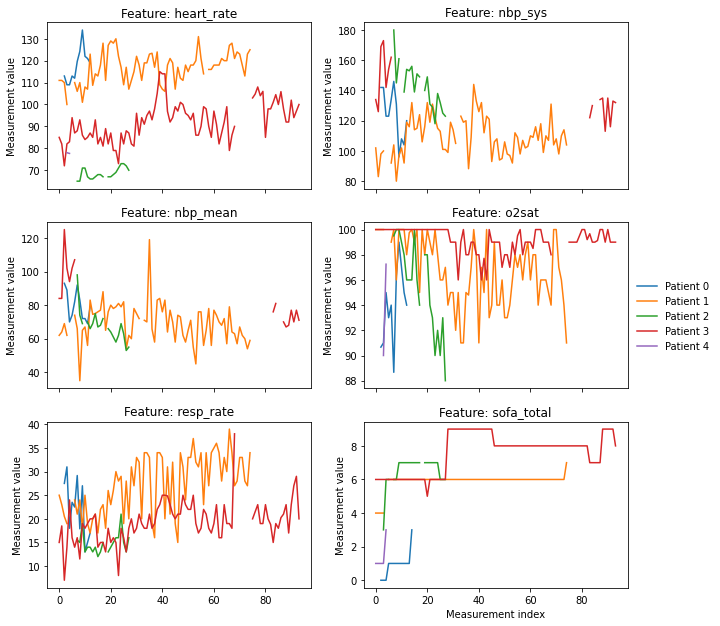

In [88]:
FEATURES_TO_PLOT = ['heart_rate', 'nbp_sys', 'nbp_mean', 'o2sat', 'resp_rate', 'sofa_total']

def plot_features(n_ids_to_plot=5, n_features_to_plot=(3, 2), figsize=(8*1.3, 8*1.3)):
    np.random.seed(9)
    ids_to_plot = np.random.choice(df['icustay_id'].unique(), size=n_ids_to_plot, replace=False)
    
    fig, axs = plt.subplots(n_features_to_plot[0], n_features_to_plot[1], sharex=True, figsize=figsize)
    for ax, feat in zip(axs.flatten(), FEATURES_TO_PLOT):
        for i, patient_id in enumerate(ids_to_plot):
            ax.set_title('Feature: {}'.format(feat))
            df[df['icustay_id'].isin([patient_id])][feat].reset_index(drop=True).plot(ax=ax, label='Patient {}'.format(i))
        ax.set_ylabel('Measurement value')

    plt.xlabel('Measurement index')
    plt.legend(loc='lower left', bbox_to_anchor=(1.02, 1.4), ncol=1, borderaxespad=0, frameon=False)
    
plot_features()

## Train Model
As our classifier, we train a gradient boosted tree, using [LightGBM](https://lightgbm.readthedocs.io/en/latest/). For illustrative purposes, we train using a fixed set of hyperparameters. These hyperparameters are based on optimising with respect to the training data, using 5-fold cross validation.

We train models across combinations of the SOFA window size $(x, y)$, sepsis onset time definitions and the prediction horizon $T$. In addition, we train separate models for the real-time and patient-level prediction tasks.

In [8]:
def train_lgbm_model(x_y=constants.xy_pairs[1:3]):
    root_dir, model_dir, _, _ = mimic3.folders(current_data='blood_only/', model='LGBM')
 
    train_dir = root_dir + 'train/'
    for x, y in x_y:
        for definition in constants.FEATURES:
            for a1 in constants.T_list:
                print(x, y, a1, definition)
                labels, features, icustay_lengths, icustay_ids = LGBM_functions.feature_loading(train_dir, definition,
                                                                                                a1, k=5, cv=False)
                
                model_hyperparameter_file = '{}lgbm_best_paras{}.pkl'.format(model_dir, definition[1:])
                with open(model_hyperparameter_file, 'rb') as file:
                    hyperparameters = pickle.load(file)
                
                model = LGBMClassifier(random_state=42).set_params(**hyperparameters)
                
                model_file = '{}{}_{}_{}{}.pkl'.format(model_dir, x, y, a1, definition[1:])
                LGBM_functions.model_fit_saving(model, features, labels, model_file)

train_lgbm_model()

Directory  /home/fosterp/mimic_code/Mimiciii_Sepsis_Label_Extraction/models/blood_only/LGBM/  already exists
Directory  /home/fosterp/mimic_code/Mimiciii_Sepsis_Label_Extraction/outputs/predictions/blood_only/LGBM/  already exists
Directory  /home/fosterp/mimic_code/Mimiciii_Sepsis_Label_Extraction/outputs/results/blood_only/LGBM/  already exists
24 12 12 t_sofa
24 12 8 t_sofa
24 12 6 t_sofa
24 12 4 t_sofa
24 12 12 t_suspicion
24 12 8 t_suspicion
24 12 6 t_suspicion
24 12 4 t_suspicion
24 12 12 t_sepsis_min
24 12 8 t_sepsis_min
24 12 6 t_sepsis_min
24 12 4 t_sepsis_min
12 6 12 t_sofa
12 6 8 t_sofa
12 6 6 t_sofa
12 6 4 t_sofa
12 6 12 t_suspicion
12 6 8 t_suspicion
12 6 6 t_suspicion
12 6 4 t_suspicion
12 6 12 t_sepsis_min
12 6 8 t_sepsis_min
12 6 6 t_sepsis_min
12 6 4 t_sepsis_min


## Evaluate Model
For each prediction task and for each combination of SOFA window size, sepsis onset time definition and prediction horizon, we evaluate the model's performance using receiver operating characteristic area under the curve (ROCAUC). For illustrative purposes, we compute in-sample performance.

In [13]:
def evaluate_lgbm_model(x_y=constants.xy_pairs[1:3], thresholds=np.arange(1, step=1/10000)):
    results = []
    results_patient_level= []
    
    root_dir, model_dir, output_predictions, output_results = mimic3.folders(current_data='blood_only/',
                                                                                    model='LGBM')
    train_dir = root_dir + 'train/'
    purpose = 'train'
    
    for x, y in x_y:                                                                                                                                                                            
        for a1 in constants.T_list:
            for definition in constants.FEATURES:
                print(x, y, a1, definition)
                             
                label = np.load('{}label_{}_{}_{}{}.npy'.format(train_dir, x, y, a1, definition[1:]))
                feature = np.load('{}james_features_{}_{}{}.npy'.format(train_dir, x, y, definition[1:]))
                
                model_file = '{}{}_{}_{}{}.pkl'.format(model_dir, x, y, a1, definition[1:])
                print('Trained model from dic:',model_file)
                preds, prob_preds, auc, specificity, accuracy = LGBM_functions.model_training(model_file, feature, label)
                
                mimic3.create_folder(output_predictions + purpose)
                output_file = '{}{}/prob_preds_{}_{}_{}{}.npy'.format(output_predictions, purpose, x, y, a1, definition[1:])
                np.save(output_file, prob_preds)
                
                results.append(['{},{}'.format(x, y), a1, definition, auc, specificity, accuracy])
                                                                                                              
                df_file = '{}{}_{}{}_dataframe.pkl'.format(train_dir, x, y, definition[1:])
                df_sepsis = pd.read_pickle(df_file)
                CMs, _, _ = mimic3_patientlevel.suboptimal_choice_patient_df(df_sepsis, label, prob_preds, a1=a1, thresholds=thresholds,sample_ids=None)     
                                                                                                
                tprs, tnrs, fnrs, pres, accs = mimic3_patientlevel.decompose_cms(CMs)

                results_patient_level.append(
                    ["{},{}".format(x, y), a1, definition, "{:.3f}".format(metrics.auc(1 - tnrs, tprs)),
                     "{:.3f}".format(mimic3_patientlevel.output_at_metric_level(tnrs, tprs, metric_required=[0.85])),
                     "{:.3f}".format(mimic3_patientlevel.output_at_metric_level(accs, tprs, metric_required=[0.85]))])
                                                                                                
    result_df = pd.DataFrame(results, columns=['x,y', 'T', 'definition', 'auc', 'specificity', 'accuracy'])
    result_df.to_csv('{}{}/lgbm_{}_results.csv'.format(output_predictions, purpose, purpose))

    results_patient_level_df = pd.DataFrame(results_patient_level,
                                            columns=['x,y', 'T', 'definition', 'auc', 'sepcificity', 'accuracy'])
    results_patient_level_df.to_csv('{}lgbm_{}_patient_level_results.csv'.format(output_results, purpose))
    
    return result_df, results_patient_level_df

result_df, results_patient_level_df = evaluate_lgbm_model()

In [35]:
result_df = pd.read_csv(str(Path(MIMIC_ANALYSIS_PATH,
                                 'outputs/predictions/blood_only/LGBM/train/lgbm_train_results.csv').resolve()))

results_patient_level_df = pd.read_csv(str(Path(MIMIC_ANALYSIS_PATH,
                                                'outputs/results/blood_only/LGBM/lgbm_train_patient_level_results.csv').resolve()))

## Plot Results
Plot results across combinations of SOFA window size, sepsis onset time definition and prediction horizon, for the real-time and patient-level prediction tasks:

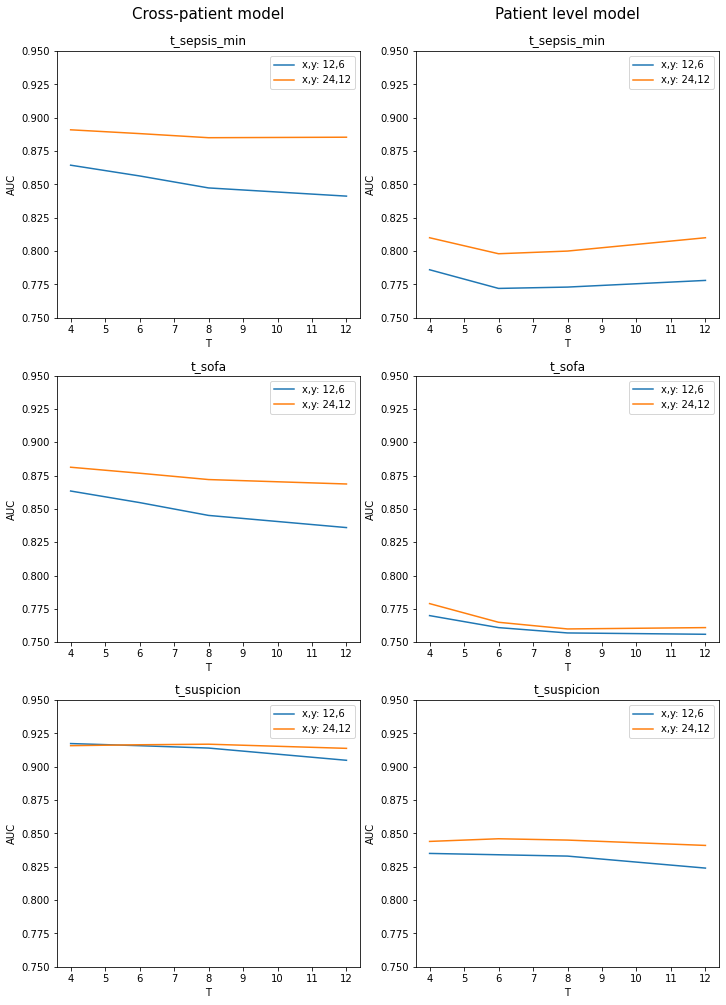

In [23]:
def plot_results(dfs=(result_df, results_patient_level_df),
                 titles=('Real-time prediction model', 'Patient level model'),
                 auc_range=(0.75, 0.95), figsize=(11, 14)):
    n_definitions = len(result_df['definition'].unique())
    n_dfs = len(dfs)

    fig, axs = plt.subplots(n_definitions, n_dfs, figsize=figsize)

    def plot_df(df, axs):
        for (group_name, df), ax in zip(df.groupby('definition'), axs):
            df.set_index('T', inplace=True)
            df.groupby('x,y')['auc'].plot(ax=ax, legend=True)

            ax.set_ylim(auc_range)
            ax.set_ylabel('AUC')
            ax.set_title(group_name)
            for text in ax.legend().get_texts():
                text.set_text('x,y: {}'.format(text.get_text()))
                
    for df, axs, title in zip(dfs, axs.T, titles):
        axs[0].annotate(title, xy=(0.5, 1.12), xytext=(0, 0), xycoords='axes fraction',
                        textcoords='offset points', size=15, ha='center', va='baseline')
        plot_df(df, axs)
        
    fig.tight_layout()
    fig.subplots_adjust(left=0.15, top=0.95)
    plt.show()

plot_results()